## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [2]:
!pip install kagglehub



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


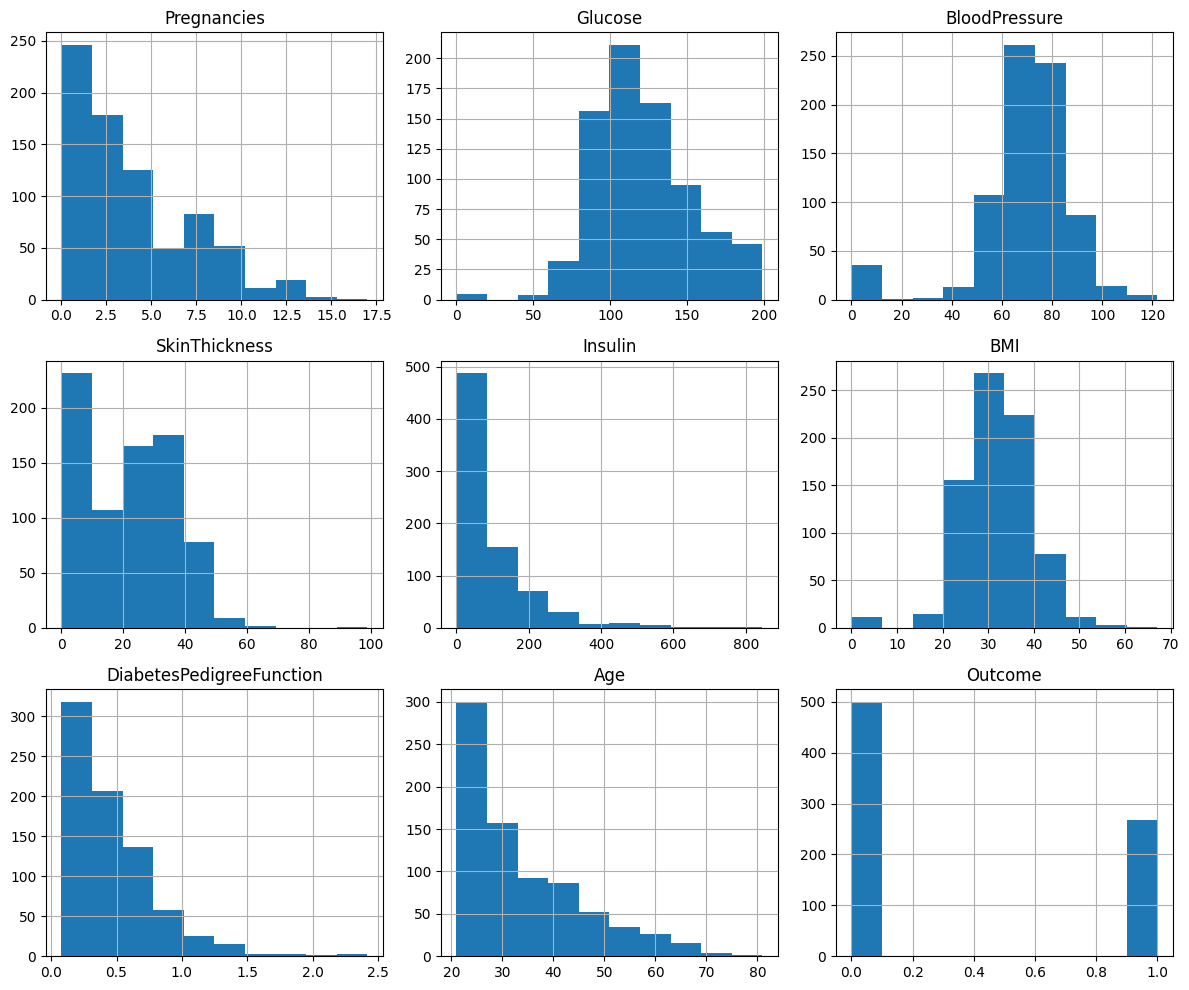

In [4]:
# Your code here
# Step 2: Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(url, names=columns)

# Step 3: EDA
df.head()
df.info()
df['Outcome'].value_counts(normalize=True)
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Step 4: Create X and y
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Step 5: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


### Problem 1 Graded Answer

In [5]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


In [6]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [7]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions

In [8]:
# Your code; add as many cells as you need

# Define model parameters
lr_params = {
    'class_weight': 'balanced',
    'max_iter': 1000
}

# Run the model using the provided helper
mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
    model=LogisticRegression,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    **lr_params
)


### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [9]:
# Insert the mean CV accuracy

a2a =  mean_cv_accuracy                            # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7576


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [10]:
# Insert the test accuracy

a2b = test_accuracy                              # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.7338


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


Sweeping n_estimators: 100%|██████████| 8/8 [00:50<00:00,  6.32s/it]


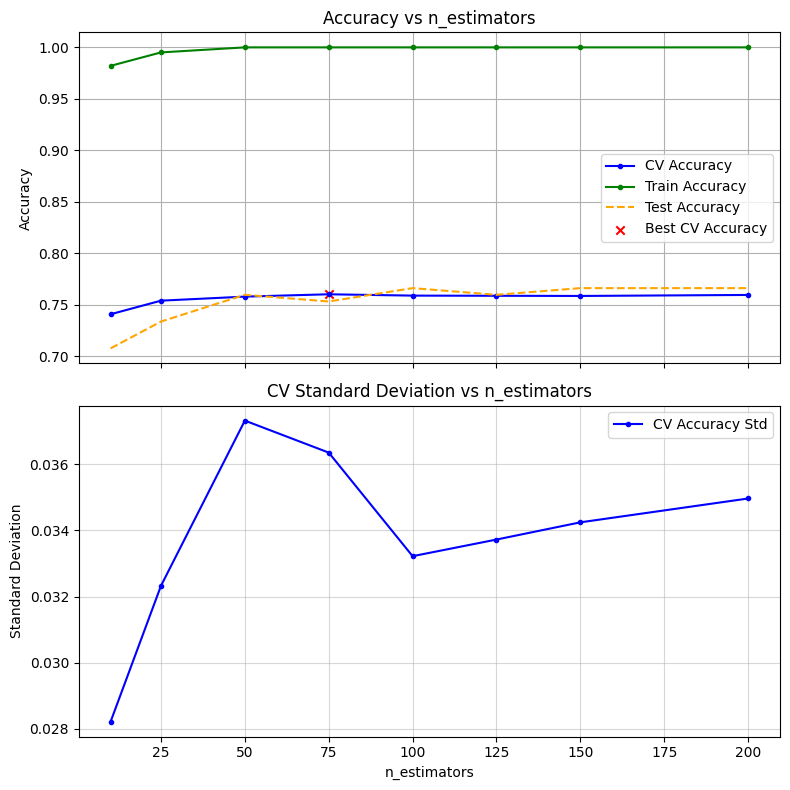

Execution Time: 00:00:50


In [11]:
# Your code here

# Define model and default parameters
rf_model = RandomForestClassifier
rf_params = {
    'random_state': 42,
    'class_weight': 'balanced'
}

# Sweep over number of trees in the forest
n_estimators_list = [10, 25, 50, 75, 100, 125, 150, 200]

# Run sweep
best_params_rf = sweep_parameter(
    model=rf_model,
    Parameters=rf_params,
    param='n_estimators',
    parameter_list=n_estimators_list,
    n_repeats=10,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)



### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [12]:
# Insert the mean CV accuracy

a3a = best_params_rf['accuracy_found']                             # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.7603


In [13]:

# Fit model with best n_estimators to get test accuracy
final_rf = rf_model(n_estimators=best_params_rf['n_estimators'],
                    random_state=42, class_weight='balanced')
final_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=75,
                       random_state=42)

### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [14]:
# Insert the test accuracy

a3b =accuracy_score(y_test, final_rf.predict(X_test))                            # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.7532
